In [3]:
import cv2
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
from torch.utils.data import random_split
import pandas as pd
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import random_split
import timm
import torch.nn.functional as F

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/COMP90086PROJECT

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/17msdf858I_Te7pkgwqj0ixH6VkN1CKv1/COMP90086PROJECT


In [ ]:
!pip install transformers

### train with 1 vs 20

read in the traing and test data

In [ ]:
# Directories
LEFT_IMG_DIR = "COMP90086_2023_TLLdataset/train/left"
RIGHT_IMG_DIR = "COMP90086_2023_TLLdataset/train/right"

# Load CSVs
train_df = pd.read_csv("COMP90086_2023_TLLdataset/train.csv")
test_candidates_df = pd.read_csv("COMP90086_2023_TLLdataset/test_candidates.csv")

def load_image_from_path(path):
    """Load an image using its path and return as numpy array."""
    return np.array(Image.open(f"{path}.jpg"))

def get_image_pair_from_row(row, left_dir, right_dir):
    """Get a pair of images as numpy arrays from a row in the dataframe."""
    left_img_path = os.path.join(left_dir, row["left"])
    right_img_path = os.path.join(right_dir, row["right"])
    return load_image_from_path(left_img_path), load_image_from_path(right_img_path)

def create_training_data_with_candidates_in_memory(df, left_dir, right_dir, num_candidates=20):
    """Create a training dataset with 20 candidates for each left image, and store them in memory."""
    left_images = []
    right_images_sets = []  # This will store lists of candidate images for each left image
    labels = []  # 1 for the correct match, 0 for the other candidates

    for _, row in df.iterrows():
        left_img_path = os.path.join(left_dir, f"{row['left']}.jpg")
        left_img = load_image_from_path(left_img_path)
        left_images.append(left_img)

        # Correct match
        right_img_path = os.path.join(right_dir, f"{row['right']}.jpg")
        candidates = [load_image_from_path(right_img_path)]
        all_right_images = df["right"].tolist()
        all_right_images.remove(row["right"])

        # Random non-matching candidates
        for _ in range(num_candidates - 1):
            random_img_name = random.choice(all_right_images)
            random_img_path = os.path.join(right_dir, f"{random_img_name}.jpg")
            candidates.append(load_image_from_path(random_img_path))

        right_images_sets.append(candidates)
        labels.append([1] + [0]*(num_candidates-1))  # 1 for the correct match, 0 for the others

    return left_images, right_images_sets, labels


In [ ]:
class SiameseNetworkDataset(Dataset):

    def __init__(self, csv_file, left_dir, right_dir, transform=None, num_candidates=20):
        self.data_frame = pd.read_csv(csv_file)
        self.left_dir = left_dir
        self.right_dir = right_dir
        self.transform = transform
        self.num_candidates = num_candidates

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        left_img_name = os.path.join(self.left_dir, f"{self.data_frame.iloc[idx, 0]}.jpg")
        left_image = Image.open(left_img_name)
        if self.transform:
            left_image = self.transform(left_image)

        # Correct match
        right_img_name = os.path.join(self.right_dir, f"{self.data_frame.iloc[idx, 1]}.jpg")
        right_images = [Image.open(right_img_name)]

        # Random non-matching candidates
        all_right_images = self.data_frame["right"].tolist()
        all_right_images.remove(self.data_frame.iloc[idx, 1])
        for _ in range(self.num_candidates - 1):
            random_img_name = random.choice(all_right_images)
            random_img_path = os.path.join(self.right_dir, f"{random_img_name}.jpg")
            right_images.append(Image.open(random_img_path))

        if self.transform:
            right_images = [self.transform(img) for img in right_images]

        # Only the first image is a correct match
        labels = torch.tensor([1] + [0] * (self.num_candidates - 1))

        return left_image, torch.stack(right_images), labels

# Applying transformations to the images.
siamese_transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resizes the image to 224x224
    transforms.ToTensor()
])


# 1. 创建完整数据集
full_dataset = SiameseNetworkDataset(
    csv_file="COMP90086_2023_TLLdataset/train.csv",
    left_dir="COMP90086_2023_TLLdataset/train/left",
    right_dir="COMP90086_2023_TLLdataset/train/right",
    transform=siamese_transform
)

# 2. 划分训练集和验证集
# 假设你想将10%的数据用作验证集
val_size = int(0.1 * len(full_dataset))
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 3. 创建DataLoaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=16)


verify if the data is loaded correctly

In [ ]:
import matplotlib.pyplot as plt

# 获取第一个批次的数据
dataiter = iter(train_loader)
left_images, right_images, labels = next(dataiter)


# 1. 可视化数据
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# 显示第一个样本的left图像和right图像
imshow(left_images[0])
imshow(right_images[0][0])  # assuming right_images[0] is a list of candidates

# 2. 检查数据形状和类型
print(left_images.shape)  # e.g., [32, 3, 200, 245] for a batch size of 32
print(right_images[0].shape)  # e.g., [20, 3, 200, 245] for 20 candidates
print(labels[0].shape)  # e.g., [20] for 20 candidates (1 correct match and 19 random matches)

# 3. 检查标签的分布
print(labels[0])  # Should see 1 followed by zeros (1 correct match and 19 random matches)


define the model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

# 定义Siamese网络结构
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128*47*58, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2)
        )

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
      # Process the left and right images directly
      output1 = self.forward_one(input1)
      output2 = self.forward_one(input2)

      return output1, output2


# Contrastive Loss
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0,num_right_images=20):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.num_right_images = num_right_images

    def forward(self, output1, output2, label):
        output1_expanded = output1.repeat(1, self.num_right_images).view(-1, output1.size(1))
        euclidean_distance = torch.norm(output1_expanded - output2, dim=1)
        print(output1.shape)
        print(output2.shape)
        print(output1-output2)
        print(euclidean_distance)
        print(label)
        loss_contrastive = torch.mean( (label) * torch.pow(euclidean_distance, 2) + (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive


train the model

In [ ]:
# 初始化网络和损失
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

num_epochs = 5
for epoch in range(num_epochs):

    # Training
    net.train()
    total_train_loss = 0
    for i, (left_images, right_images_set, labels_set) in enumerate(train_loader):
        left_images = left_images.cuda()

        batch_loss = 0  # Accumulate loss for this batch here
        optimizer.zero_grad()

        # Iterate over each left image and its set of right images
        for j in range(left_images.size(0)):
            left_img = left_images[j].unsqueeze(0)
            right_images = right_images_set[j].cuda()
            labels = labels_set[j].cuda()

            # Calculate model output
            output1, output2 = net(left_img, right_images)

            # Calculate loss for this set
            loss = criterion(output1, output2, labels)
            batch_loss += loss

        batch_loss.backward()
        optimizer.step()
        total_train_loss += batch_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    net.eval()
    total_val_loss = 0
    with torch.no_grad():  # Do not calculate gradients for validation
        for i, (left_images, right_images_set, labels_set) in enumerate(val_loader):
            left_images = left_images.cuda()
            batch_loss = 0  # Accumulate loss for this batch here

            # Iterate over each left image and its set of right images
            for j in range(left_images.size(0)):
                left_img = left_images[j].unsqueeze(0)
                right_images = right_images_set[j].cuda()
                labels = labels_set[j].cuda()

                # Calculate model output
                output1, output2 = net(left_img, right_images)

                # Calculate loss for this set
                loss = criterion(output1, output2, labels)
                batch_loss += loss

            total_val_loss += batch_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


print("Training and Validation Finished!")


Epoch 1, Training Loss: 0.8257, Validation Loss: 0.7689
Epoch 2, Training Loss: 0.7682, Validation Loss: 0.7673
Epoch 3, Training Loss: 0.7680, Validation Loss: 0.7679
Epoch 4, Training Loss: 0.7679, Validation Loss: 0.7679
Epoch 5, Training Loss: 0.7676, Validation Loss: 0.7673
Training and Validation Finished!


In [ ]:
# 指定保存路径
model_save_path = "siamese_model_5.pth"

# 保存模型权重
torch.save(net.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to siamese_model_5.pth


load the trained model

In [ ]:
# 实例化模型
model = SiameseNetwork()

# 加载权重
model_weights = torch.load("siamese_model_5.pth")
model.load_state_dict(model_weights)

# 设置为评估模式
model.eval()

# 如果你在GPU上进行推断，记得转移模型到GPU
if torch.cuda.is_available():
    model = model.cuda()


In [ ]:
test_df = pd.read_csv("COMP90086_2023_TLLdataset/test_candidates.csv")

LEFT_IMG_DIR_TEST = "COMP90086_2023_TLLdataset/test/left"
RIGHT_IMG_DIR_TEST = "COMP90086_2023_TLLdataset/test/right"

all_similarities = []

with torch.no_grad():
    for index, row in test_df.iterrows():
        left_img_name = row['left']
        left_img_path = os.path.join(LEFT_IMG_DIR_TEST, left_img_name)
        left_img = torch.from_numpy(load_image_from_path(left_img_path)).float().permute(2, 0, 1).unsqueeze(0).cuda()

        # Collect all 20 candidate right images for the given left image
        right_images = []
        for c in range(20):  # For each of the candidates
            right_img_name = row[f'c{c}']
            right_img_path = os.path.join(RIGHT_IMG_DIR_TEST, right_img_name)
            right_img = torch.from_numpy(load_image_from_path(right_img_path)).float().permute(2, 0, 1).unsqueeze(0).cuda()
            right_images.append(right_img)

        # Stack all right images into a single tensor
        right_images_tensor = torch.cat(right_images, 0)

        # Expand left_img tensor to match the shape of right_images_tensor
        left_images_expanded = left_img.expand_as(right_images_tensor)

        # Get the model outputs
        output1, output2 = model(left_images_expanded, right_images_tensor)

        # Compute similarities for all pairs and append to all_similarities list
        euclidean_distances = torch.norm(output1 - output2, dim=1)
        similarities = 1 / (1 + euclidean_distances.cpu().numpy())
        all_similarities.append(similarities)

# Convert to DataFrame and save to CSV
similarities_df = pd.DataFrame(all_similarities, columns=[f'c{i}' for i in range(20)])
similarities_df.insert(0, 'left', test_df['left'])
similarities_df.to_csv("similarities.csv", index=False)


In [ ]:
num_epochs = 5
for epoch in range(num_epochs):

    # Training
    model.train()
    total_train_loss = 0
    for i, (left_images, right_images_set, labels_set) in enumerate(train_loader):
        left_images = left_images.cuda()

        batch_loss = 0  # Accumulate loss for this batch here
        optimizer.zero_grad()

        # Iterate over each left image and its set of right images
        for j in range(left_images.size(0)):
            left_img = left_images[j].unsqueeze(0)
            right_images = right_images_set[j].cuda()
            labels = labels_set[j].cuda()

            # Calculate model output
            output1, output2 = model(left_img, right_images)

            # Calculate loss for this set
            loss = criterion(output1, output2, labels)
            batch_loss += loss

        batch_loss.backward()
        optimizer.step()
        total_train_loss += batch_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():  # Do not calculate gradients for validation
        for i, (left_images, right_images_set, labels_set) in enumerate(val_loader):
            left_images = left_images.cuda()
            batch_loss = 0  # Accumulate loss for this batch here

            # Iterate over each left image and its set of right images
            for j in range(left_images.size(0)):
                left_img = left_images[j].unsqueeze(0)
                right_images = right_images_set[j].cuda()
                labels = labels_set[j].cuda()

                # Calculate model output
                output1, output2 = net(left_img, right_images)

                # Calculate loss for this set
                loss = criterion(output1, output2, labels)
                batch_loss += loss

            total_val_loss += batch_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


print("Training and Validation Finished!")

Epoch 1, Training Loss: 0.7674, Validation Loss: 0.7674
Epoch 2, Training Loss: 0.7675, Validation Loss: 0.7675
Epoch 3, Training Loss: 0.7675, Validation Loss: 0.7674
Epoch 4, Training Loss: 0.7674, Validation Loss: 0.7673
Epoch 5, Training Loss: 0.7674, Validation Loss: 0.7672
Training and Validation Finished!


### visual embeddings dataset

In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.8 MB/s eta 0:00:00


#### PCA 1024 with ViT

turn train set into embeddings

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
train_data = CustomDataset(root_dir='COMP90086_2023_TLLdataset/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

# 加载预训练的ViT模型
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model = model.eval().cuda()

# 为了保存embeddings，首先确保目标文件夹存在
output_dir = "COMP90086_2023_TLLdataset/train_embeddings_PCA"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for folder in ['left', 'right']:
    if not os.path.exists(os.path.join(output_dir, folder)):
        os.makedirs(os.path.join(output_dir, folder))

from sklearn.decomposition import PCA

# 定义PCA降维的目标维数
n_components = 1024  # 作为示例，你可以根据需要更改

# 为了使用PCA，我们需要先收集所有的embeddings
all_features = []

with torch.no_grad():
    for images, paths in train_loader:
        images = images.cuda()
        features = model.forward_features(images)
        all_features.append(features.reshape(features.size(0), -1).cpu().numpy())  # Flatten each feature

all_features = np.vstack(all_features)

# 使用PCA降维
pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(all_features)

# 保存降维后的embeddings
for idx, path in enumerate(train_data.image_paths):
    folder_name = os.path.split(os.path.dirname(path))[-1]
    base_name = os.path.basename(path).replace('.jpg', '.npy')
    output_path = os.path.join(output_dir, folder_name, base_name)
    np.save(output_path, reduced_features[idx])


turn test set into embeddings

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# 加载数据集
test_data = CustomDataset(root_dir='COMP90086_2023_TLLdataset/test', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 加载预训练的ViT模型
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model = model.eval().cuda()

# 为了保存embeddings，首先确保目标文件夹存在
output_dir = "COMP90086_2023_TLLdataset/train_embeddings_PCA_test"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for folder in ['left', 'right']:
    if not os.path.exists(os.path.join(output_dir, folder)):
        os.makedirs(os.path.join(output_dir, folder))

from sklearn.decomposition import PCA

# 定义PCA降维的目标维数
n_components = 1024  # 作为示例，你可以根据需要更改

# 为了使用PCA，我们需要先收集所有的embeddings
all_features = []

with torch.no_grad():
    for images, paths in test_loader:
        images = images.cuda()
        features = model.forward_features(images)
        all_features.append(features.reshape(features.size(0), -1).cpu().numpy())  # Flatten each feature

all_features = np.vstack(all_features)

# 使用PCA降维
pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(all_features)

# 保存降维后的embeddings
for idx, path in enumerate(test_data.image_paths):
    folder_name = os.path.split(os.path.dirname(path))[-1]
    base_name = os.path.basename(path).replace('.jpg', '.npy')
    output_path = os.path.join(output_dir, folder_name, base_name)
    np.save(output_path, reduced_features[idx])


##### Define the dataloader

In [5]:
import pandas as pd

class PairwiseDataset(Dataset):
    def __init__(self, left_embeddings_dir, right_embeddings_dir, csv_path, transform=None):
        self.left_embeddings = [os.path.join(left_embeddings_dir, f) for f in os.listdir(left_embeddings_dir)]
        self.right_embeddings = [os.path.join(right_embeddings_dir, f) for f in os.listdir(right_embeddings_dir)]
        self.transform = transform

        # 读取CSV文件并为每个left图像创建一个字典来存储其匹配的right图像
        self.matching_dict = {}
        df = pd.read_csv(csv_path)
        for index, row in df.iterrows():
            left_path = os.path.join(left_embeddings_dir, row['left'] + '.npy')
            right_path = os.path.join(right_embeddings_dir, row['right'] + '.npy')
            self.matching_dict[left_path] = right_path

    def __len__(self):
        return len(self.left_embeddings)

    def __getitem__(self, idx):
        left_embedding = np.load(self.left_embeddings[idx])
        # 从字典中获取与left图像匹配的right图像
        matched_right_path = self.matching_dict[self.left_embeddings[idx]]

        # 我们随机选择19个右边的图像，并添加一个匹配的right图像作为候选项。
        random_choices = np.random.choice([path for path in self.right_embeddings if path != matched_right_path], 19, replace=False).tolist()
        random_choices.append(matched_right_path)

        right_embeddings = [np.load(path) for path in random_choices]

        # 获取文件名（没有扩展名）
        left_name = os.path.splitext(os.path.basename(self.left_embeddings[idx]))[0]
        right_names = [os.path.splitext(os.path.basename(path))[0] for path in random_choices]

        return torch.Tensor(left_embedding), torch.stack([torch.Tensor(emb) for emb in right_embeddings]), left_name, right_names


LR model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 定义模型
class AdaptationModule(nn.Module):
    def __init__(self, input_dim):
        super(AdaptationModule, self).__init__()
        self.linear = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        return nn.ReLU()(self.linear(x))

model_shared = AdaptationModule(1024).cuda()

optimizer = optim.Adam(model_shared.parameters(), lr=0.001)

# 2. 相似性函数
def sim_matrix(a, b, eps=1e-8):
    """
    Calculate the similarity matrix given two lists of embeddings.
    added eps for numerical stability.
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))

    return sim_mt

sigma = 10.0  # Temperature parameter

# 3. 损失函数
def compute_loss(similarity, target):
    similarity = similarity * sigma
    return nn.CrossEntropyLoss()(similarity, target)

def evaluate(model_shared, val_loader):
    model_shared.eval()

    total_loss = 0.0
    correct_predictions = 0.0

    with torch.no_grad():
        for batch_left, batch_right in val_loader:
            a_left = model_shared(batch_left.cuda())
            a_right_candidates = [model_shared(emb.cuda()) for emb in torch.unbind(batch_right, dim=1)]

            for a_right in a_right_candidates:
                sim_left_to_right = sim_matrix(a_left, a_right)

                # Compute target
                target = torch.arange(batch_left.size(0)).cuda()

                loss_left_to_right = compute_loss(sim_left_to_right, target)
                total_loss += loss_left_to_right.item()

                # Calculate the number of correct predictions
                correct_predictions += (sim_left_to_right.argmax(dim=1) == target).sum().item()

    avg_loss = total_loss / len(val_loader.dataset)
    accuracy = correct_predictions / len(val_loader.dataset)

    return avg_loss, accuracy


read the data, initialize model and get ready for train

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split

# Assuming you've defined your dataset
dataset = PairwiseDataset('COMP90086_2023_TLLdataset/train_embeddings_PCA/left', 'COMP90086_2023_TLLdataset/train_embeddings_PCA/right','COMP90086_2023_TLLdataset/train.csv')

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


train the model

In [ ]:
epochs = 7
for epoch in range(epochs):
    # Train
    model_shared.train()
    for batch_left, batch_right in train_loader:
        optimizer.zero_grad()

        a_left = model_shared(batch_left.cuda())

        # 为每个右边的候选图像计算adapted embeddings
        a_right_candidates = [model_shared(emb.cuda()) for emb in torch.unbind(batch_right, dim=1)]

        losses = []
        for a_right in a_right_candidates:
            sim_left_to_right = sim_matrix(a_left, a_right)
            sim_right_to_left = sim_matrix(a_right, a_left)

            # Compute target.
            target = torch.arange(batch_left.size(0)).cuda()

            loss_left_to_right = compute_loss(sim_left_to_right, target)
            loss_right_to_left = compute_loss(sim_right_to_left, target)

            # Combined loss
            loss = (loss_left_to_right + loss_right_to_left) / 2
            losses.append(loss)

        # 求平均loss并进行反向传播
        total_loss = sum(losses) / len(losses)
        total_loss.backward()
        optimizer.step()

    # Evaluate after each epoch
    val_loss, val_accuracy = evaluate(model_shared, val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/7, Validation Loss: 1.4005, Validation Accuracy: 0.6550
Epoch 2/7, Validation Loss: 1.4007, Validation Accuracy: 0.6450
Epoch 3/7, Validation Loss: 1.3973, Validation Accuracy: 0.6425
Epoch 4/7, Validation Loss: 1.3948, Validation Accuracy: 0.7075
Epoch 5/7, Validation Loss: 1.3977, Validation Accuracy: 0.6350
Epoch 6/7, Validation Loss: 1.3943, Validation Accuracy: 0.5850
Epoch 7/7, Validation Loss: 1.3943, Validation Accuracy: 0.6700


predict the test set

In [ ]:
import csv
import numpy as np
import torch
model_shared.eval()
def compute_similarity(embed_left, embed_right):
    # 获取模型的adapted embeddings
    a_left = model_shared(torch.tensor(embed_left).cuda().unsqueeze(0))  # 加unsqueeze(0)以保证维度正确
    a_right = model_shared(torch.tensor(embed_right).cuda().unsqueeze(0))

    similarity = sim_matrix(a_left, a_right)

    return similarity.item()  # 将1x1 tensor转换为单个Python数值

# 加载test数据集的left和candidates的embeddings
def load_embedding(path):
    return np.load(path)

# 加载test_candidates.csv并计算相似度
output = []
with open('COMP90086_2023_TLLdataset/test_candidates.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        left_name = row[0]
        left_embedding = load_embedding(f"COMP90086_2023_TLLdataset/train_embeddings_PCA_test/left/{left_name}.npy")

        similarities = [left_name]
        for candidate_name in row[1:]:
            candidate_embedding = load_embedding(f"COMP90086_2023_TLLdataset/train_embeddings_PCA_test/right/{candidate_name}.npy")

            sim = compute_similarity(left_embedding, candidate_embedding)
            similarities.append(sim)

        output.append(similarities)

# 保存结果到CSV
with open('output_similarities.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['left', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19'])
    for row in output:
        writer.writerow(row)


#### PCA 2048 with ViT

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
train_data = CustomDataset(root_dir='COMP90086_2023_TLLdataset/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

# 加载预训练的ViT模型
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model = model.eval().cuda()

# 为了保存embeddings，首先确保目标文件夹存在
output_dir = "COMP90086_2023_TLLdataset/train_embeddings_PCA_train_2048"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for folder in ['left', 'right']:
    if not os.path.exists(os.path.join(output_dir, folder)):
        os.makedirs(os.path.join(output_dir, folder))

from sklearn.decomposition import PCA

# 定义PCA降维的目标维数
n_components = 2048  # 作为示例，你可以根据需要更改

# 为了使用PCA，我们需要先收集所有的embeddings
all_features = []

with torch.no_grad():
    for images, paths in train_loader:
        images = images.cuda()
        features = model.forward_features(images)
        all_features.append(features.reshape(features.size(0), -1).cpu().numpy())  # Flatten each feature

all_features = np.vstack(all_features)

# 使用PCA降维
pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(all_features)

# 保存降维后的embeddings
for idx, path in enumerate(train_data.image_paths):
    folder_name = os.path.split(os.path.dirname(path))[-1]
    base_name = os.path.basename(path).replace('.jpg', '.npy')
    output_path = os.path.join(output_dir, folder_name, base_name)
    np.save(output_path, reduced_features[idx])


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split

# Assuming you've defined your dataset
dataset = PairwiseDataset('COMP90086_2023_TLLdataset/train_embeddings_PCA_train_2048/left', 'COMP90086_2023_TLLdataset/train_embeddings_PCA_train_2048/right','COMP90086_2023_TLLdataset/train.csv')

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 定义模型
class AdaptationModule(nn.Module):
    def __init__(self, input_dim):
        super(AdaptationModule, self).__init__()

        # First linear layer
        self.linear1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(p=0.5)

        # Second linear layer
        self.linear2 = nn.Linear(1024, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(p=0.5)

        # Third linear layer (output layer)
        self.linear3 = nn.Linear(1024, 1024)

    def forward(self, x):
        x = self.dropout1(self.bn1(F.relu(self.linear1(x))))
        x = self.dropout2(self.bn2(F.relu(self.linear2(x))))
        x = F.relu(self.linear3(x))
        return x

model_shared = AdaptationModule(2048).cuda()

optimizer = optim.Adam(model_shared.parameters(), lr=0.001)

# 2. 相似性函数
def sim_matrix(a, b, eps=1e-8):
    """
    Calculate the similarity matrix given two lists of embeddings.
    added eps for numerical stability.
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))

    return sim_mt

sigma = 10.0  # Temperature parameter

# 3. 损失函数
def compute_loss(similarity, target):
    similarity = similarity * sigma
    return nn.CrossEntropyLoss()(similarity, target)

def evaluate(model_shared, val_loader):
    model_shared.eval()

    total_loss = 0.0
    correct_predictions = 0.0

    with torch.no_grad():
        for batch_left, batch_right in val_loader:
            a_left = model_shared(batch_left.cuda())
            a_right_candidates = [model_shared(emb.cuda()) for emb in torch.unbind(batch_right, dim=1)]

            for a_right in a_right_candidates:
                sim_left_to_right = sim_matrix(a_left, a_right)

                # Compute target
                target = torch.arange(batch_left.size(0)).cuda()

                loss_left_to_right = compute_loss(sim_left_to_right, target)
                total_loss += loss_left_to_right.item()

                # Calculate the number of correct predictions
                correct_predictions += (sim_left_to_right.argmax(dim=1) == target).sum().item()

    avg_loss = total_loss / len(val_loader.dataset)
    accuracy = correct_predictions / len(val_loader.dataset)

    return avg_loss, accuracy


In [ ]:
epochs = 5
for epoch in range(epochs):
    # Train
    model_shared.train()
    for batch_left, batch_right in train_loader:
        optimizer.zero_grad()

        a_left = model_shared(batch_left.cuda())

        # 为每个右边的候选图像计算adapted embeddings
        a_right_candidates = [model_shared(emb.cuda()) for emb in torch.unbind(batch_right, dim=1)]

        losses = []
        for a_right in a_right_candidates:
            sim_left_to_right = sim_matrix(a_left, a_right)
            sim_right_to_left = sim_matrix(a_right, a_left)

            # Compute target.
            target = torch.arange(batch_left.size(0)).cuda()

            loss_left_to_right = compute_loss(sim_left_to_right, target)
            loss_right_to_left = compute_loss(sim_right_to_left, target)

            # Combined loss
            loss = (loss_left_to_right + loss_right_to_left) / 2
            losses.append(loss)

        # 求平均loss并进行反向传播
        total_loss = sum(losses) / len(losses)
        total_loss.backward()
        optimizer.step()

    # Evaluate after each epoch
    val_loss, val_accuracy = evaluate(model_shared, val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/5, Validation Loss: 1.4321, Validation Accuracy: 0.5350
Epoch 2/5, Validation Loss: 1.4298, Validation Accuracy: 0.5675
Epoch 3/5, Validation Loss: 1.4256, Validation Accuracy: 0.5575
Epoch 4/5, Validation Loss: 1.4276, Validation Accuracy: 0.6000
Epoch 5/5, Validation Loss: 1.4289, Validation Accuracy: 0.5425


In [ ]:
import csv
import numpy as np
import torch
model_shared.eval()
def compute_similarity(embed_left, embed_right):
    # 获取模型的adapted embeddings
    a_left = model_shared(torch.tensor(embed_left).cuda().unsqueeze(0))  # 加unsqueeze(0)以保证维度正确
    a_right = model_shared(torch.tensor(embed_right).cuda().unsqueeze(0))

    similarity = sim_matrix(a_left, a_right)

    return similarity.item()  # 将1x1 tensor转换为单个Python数值

# 加载test数据集的left和candidates的embeddings
def load_embedding(path):
    return np.load(path)

# 加载test_candidates.csv并计算相似度
output = []
with open('COMP90086_2023_TLLdataset/test_candidates.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        left_name = row[0]
        left_embedding = load_embedding(f"COMP90086_2023_TLLdataset/train_embeddings_PCA_test/left/{left_name}.npy")

        similarities = [left_name]
        for candidate_name in row[1:]:
            candidate_embedding = load_embedding(f"COMP90086_2023_TLLdataset/train_embeddings_PCA_test/right/{candidate_name}.npy")

            sim = compute_similarity(left_embedding, candidate_embedding)
            similarities.append(sim)

        output.append(similarities)

# 保存结果到CSV
with open('output_similarities.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['left', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19'])
    for row in output:
        writer.writerow(row)


#### PCA 512 with ViT

turn train into embeddings 512

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
train_data = CustomDataset(root_dir='COMP90086_2023_TLLdataset/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

# 加载预训练的ViT模型
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model = model.eval().cuda()

# 为了保存embeddings，首先确保目标文件夹存在
output_dir = "COMP90086_2023_TLLdataset/train_embeddings_PCA_train_512"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for folder in ['left', 'right']:
    if not os.path.exists(os.path.join(output_dir, folder)):
        os.makedirs(os.path.join(output_dir, folder))

from sklearn.decomposition import PCA

# 定义PCA降维的目标维数
n_components = 512  # 作为示例，你可以根据需要更改

# 为了使用PCA，我们需要先收集所有的embeddings
all_features = []

with torch.no_grad():
    for images, paths in train_loader:
        images = images.cuda()
        features = model.forward_features(images)
        all_features.append(features.reshape(features.size(0), -1).cpu().numpy())  # Flatten each feature

all_features = np.vstack(all_features)

# 使用PCA降维
pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(all_features)

# 保存降维后的embeddings
for idx, path in enumerate(train_data.image_paths):
    folder_name = os.path.split(os.path.dirname(path))[-1]
    base_name = os.path.basename(path).replace('.jpg', '.npy')
    output_path = os.path.join(output_dir, folder_name, base_name)
    np.save(output_path, reduced_features[idx])


turn test set into embeddings 512

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# 加载数据集
test_data = CustomDataset(root_dir='COMP90086_2023_TLLdataset/test', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 加载预训练的ViT模型
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model = model.eval().cuda()

# 为了保存embeddings，首先确保目标文件夹存在
output_dir = "COMP90086_2023_TLLdataset/train_embeddings_PCA_test_512"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for folder in ['left', 'right']:
    if not os.path.exists(os.path.join(output_dir, folder)):
        os.makedirs(os.path.join(output_dir, folder))

from sklearn.decomposition import PCA

# 定义PCA降维的目标维数
n_components = 512  # 作为示例，你可以根据需要更改

# 为了使用PCA，我们需要先收集所有的embeddings
all_features = []

with torch.no_grad():
    for images, paths in test_loader:
        images = images.cuda()
        features = model.forward_features(images)
        all_features.append(features.reshape(features.size(0), -1).cpu().numpy())  # Flatten each feature

all_features = np.vstack(all_features)

# 使用PCA降维
pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(all_features)

# 保存降维后的embeddings
for idx, path in enumerate(test_data.image_paths):
    folder_name = os.path.split(os.path.dirname(path))[-1]
    base_name = os.path.basename(path).replace('.jpg', '.npy')
    output_path = os.path.join(output_dir, folder_name, base_name)
    np.save(output_path, reduced_features[idx])


read the embeddings train set

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split

# Assuming you've defined your dataset
dataset = PairwiseDataset('COMP90086_2023_TLLdataset/train_embeddings_PCA_train_512/left', 'COMP90086_2023_TLLdataset/train_embeddings_PCA_train_512/right','COMP90086_2023_TLLdataset/train.csv')

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 定义模型
class AdaptationModule(nn.Module):
    def __init__(self, input_dim):
        super(AdaptationModule, self).__init__()
        self.linear = nn.Linear(input_dim, 1024)

    def forward(self, x):
        return nn.ReLU()(self.linear(x))

model_shared = AdaptationModule(512).cuda()

optimizer = optim.Adam(model_shared.parameters(), lr=0.001)

# 2. 相似性函数
def sim_matrix(a, b, eps=1e-8):
    """
    Calculate the similarity matrix given two lists of embeddings.
    added eps for numerical stability.
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))

    return sim_mt

sigma = 10.0  # Temperature parameter

# 3. 损失函数
def compute_loss(similarity, target):
    similarity = similarity * sigma
    return nn.CrossEntropyLoss()(similarity, target)

def evaluate(model_shared, val_loader):
    model_shared.eval()

    total_loss = 0.0
    correct_predictions = 0.0

    with torch.no_grad():
        for batch_left, batch_right in val_loader:
            a_left = model_shared(batch_left.cuda())
            a_right_candidates = [model_shared(emb.cuda()) for emb in torch.unbind(batch_right, dim=1)]

            for a_right in a_right_candidates:
                sim_left_to_right = sim_matrix(a_left, a_right)

                # Compute target
                target = torch.arange(batch_left.size(0)).cuda()

                loss_left_to_right = compute_loss(sim_left_to_right, target)
                total_loss += loss_left_to_right.item()

                # Calculate the number of correct predictions
                correct_predictions += (sim_left_to_right.argmax(dim=1) == target).sum().item()

    avg_loss = total_loss / len(val_loader.dataset)
    accuracy = correct_predictions / len(val_loader.dataset)

    return avg_loss, accuracy


In [ ]:
epochs = 5
for epoch in range(epochs):
    # Train
    model_shared.train()
    for batch_left, batch_right in train_loader:
        optimizer.zero_grad()

        a_left = model_shared(batch_left.cuda())

        # 为每个右边的候选图像计算adapted embeddings
        a_right_candidates = [model_shared(emb.cuda()) for emb in torch.unbind(batch_right, dim=1)]

        losses = []
        for a_right in a_right_candidates:
            sim_left_to_right = sim_matrix(a_left, a_right)
            sim_right_to_left = sim_matrix(a_right, a_left)

            # Compute target.
            target = torch.arange(batch_left.size(0)).cuda()

            loss_left_to_right = compute_loss(sim_left_to_right, target)
            loss_right_to_left = compute_loss(sim_right_to_left, target)

            # Combined loss
            loss = (loss_left_to_right + loss_right_to_left) / 2
            losses.append(loss)

        # 求平均loss并进行反向传播
        total_loss = sum(losses) / len(losses)
        total_loss.backward()
        optimizer.step()

    # Evaluate after each epoch
    val_loss, val_accuracy = evaluate(model_shared, val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/5, Validation Loss: 1.3997, Validation Accuracy: 0.7000
Epoch 2/5, Validation Loss: 1.3993, Validation Accuracy: 0.6925
Epoch 3/5, Validation Loss: 1.3991, Validation Accuracy: 0.6400
Epoch 4/5, Validation Loss: 1.3963, Validation Accuracy: 0.6550
Epoch 5/5, Validation Loss: 1.3976, Validation Accuracy: 0.6900


read test embeddings set and predict

In [ ]:
import csv
import numpy as np
import torch
model_shared.eval()
def compute_similarity(embed_left, embed_right):
    # 获取模型的adapted embeddings
    a_left = model_shared(torch.tensor(embed_left).cuda().unsqueeze(0))  # 加unsqueeze(0)以保证维度正确
    a_right = model_shared(torch.tensor(embed_right).cuda().unsqueeze(0))

    similarity = sim_matrix(a_left, a_right)

    return similarity.item()  # 将1x1 tensor转换为单个Python数值

# 加载test数据集的left和candidates的embeddings
def load_embedding(path):
    return np.load(path)

# 加载test_candidates.csv并计算相似度
output = []
with open('COMP90086_2023_TLLdataset/test_candidates.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        left_name = row[0]
        left_embedding = load_embedding(f"COMP90086_2023_TLLdataset/train_embeddings_PCA_test_512/left/{left_name}.npy")

        similarities = [left_name]
        for candidate_name in row[1:]:
            candidate_embedding = load_embedding(f"COMP90086_2023_TLLdataset/train_embeddings_PCA_test_512/right/{candidate_name}.npy")

            sim = compute_similarity(left_embedding, candidate_embedding)
            similarities.append(sim)

        output.append(similarities)

# 保存结果到CSV
with open('output_similarities_512.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['left', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19'])
    for row in output:
        writer.writerow(row)


#### ViT and Facenet

In [2]:
pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.7 MB/s eta 0:00:00


turn the train into merged_embeddings

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from facenet_pytorch import InceptionResnetV1
import timm
from sklearn.decomposition import PCA
from torch.nn import AdaptiveAvgPool2d

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
train_data = CustomDataset(root_dir='COMP90086_2023_TLLdataset/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

# 加载预训练的ViT模型和FaceNet模型
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True).eval().cuda()
face_model = InceptionResnetV1(pretrained="vggface2").eval().cuda()
avg_pool = AdaptiveAvgPool2d((1, 1))

def extract_merged_embeddings(images):
    # 从ViT模型中提取embeddings
    vit_embeddings = vit_model.forward_features(images)
    vit_embeddings = vit_embeddings.reshape(vit_embeddings.size(0), -1)

    # 从FaceNet模型中提取embeddings
    face_embeddings = face_model(images)
    if len(face_embeddings.shape) == 4:
      face_embeddings = avg_pool(face_embeddings).squeeze(-1).squeeze(-1)

    # 合并两个embeddings
    merged_embeddings = torch.cat([vit_embeddings, face_embeddings], dim=1)

    return merged_embeddings

# 收集所有的merged embeddings
all_merged_embeddings = []

with torch.no_grad():
    for images, _ in train_loader:
        images = images.cuda()
        embeddings = extract_merged_embeddings(images)
        embeddings = embeddings.cpu()
        all_merged_embeddings.append(embeddings.numpy())

all_merged_embeddings = np.vstack(all_merged_embeddings)

# 使用PCA降维
n_components = 256
pca = PCA(n_components=n_components)
reduced_merged_embeddings = pca.fit_transform(all_merged_embeddings)

# 保存降维后的merged embeddings
output_dir = "COMP90086_2023_TLLdataset/train_merged_embeddings_ViT_Facenet"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for folder in ['left', 'right']:
    if not os.path.exists(os.path.join(output_dir, folder)):
        os.makedirs(os.path.join(output_dir, folder))

for idx, path in enumerate(train_data.image_paths):
    folder_name = os.path.split(os.path.dirname(path))[-1]
    base_name = os.path.basename(path).replace('.jpg', '.npy')
    output_path = os.path.join(output_dir, folder_name, base_name)
    np.save(output_path, reduced_merged_embeddings[idx])


turn the test into merged_embeddings

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from facenet_pytorch import InceptionResnetV1
import timm
from sklearn.decomposition import PCA
from torch.nn import AdaptiveAvgPool2d

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
train_data = CustomDataset(root_dir='COMP90086_2023_TLLdataset/test', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

# 加载预训练的ViT模型和FaceNet模型
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True).eval().cuda()
face_model = InceptionResnetV1(pretrained="vggface2").eval().cuda()
avg_pool = AdaptiveAvgPool2d((1, 1))

def extract_merged_embeddings(images):
    # 从ViT模型中提取embeddings
    vit_embeddings = vit_model.forward_features(images)
    vit_embeddings = vit_embeddings.reshape(vit_embeddings.size(0), -1)

    # 从FaceNet模型中提取embeddings
    face_embeddings = face_model(images)
    if len(face_embeddings.shape) == 4:
      face_embeddings = avg_pool(face_embeddings).squeeze(-1).squeeze(-1)

    # 合并两个embeddings
    merged_embeddings = torch.cat([vit_embeddings, face_embeddings], dim=1)

    return merged_embeddings

# 收集所有的merged embeddings
all_merged_embeddings = []

with torch.no_grad():
    for images, _ in train_loader:
        images = images.cuda()
        embeddings = extract_merged_embeddings(images)
        embeddings = embeddings.cpu()
        all_merged_embeddings.append(embeddings.numpy())

all_merged_embeddings = np.vstack(all_merged_embeddings)

# 使用PCA降维
n_components = 256
pca = PCA(n_components=n_components)
reduced_merged_embeddings = pca.fit_transform(all_merged_embeddings)

# 保存降维后的merged embeddings
output_dir = "COMP90086_2023_TLLdataset/test_merged_embeddings_ViT_Facenet_256"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for folder in ['left', 'right']:
    if not os.path.exists(os.path.join(output_dir, folder)):
        os.makedirs(os.path.join(output_dir, folder))

for idx, path in enumerate(train_data.image_paths):
    folder_name = os.path.split(os.path.dirname(path))[-1]
    base_name = os.path.basename(path).replace('.jpg', '.npy')
    output_path = os.path.join(output_dir, folder_name, base_name)
    np.save(output_path, reduced_merged_embeddings[idx])


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split

# Assuming you've defined your dataset
dataset = PairwiseDataset('COMP90086_2023_TLLdataset/train_merged_embeddings_ViT_Facenet_256/left', 'COMP90086_2023_TLLdataset/train_merged_embeddings_ViT_Facenet_256/right','COMP90086_2023_TLLdataset/train.csv')

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64,num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64,num_workers=2, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 定义模型
class AdaptationModule(nn.Module):
    def __init__(self, input_dim):
        super(AdaptationModule, self).__init__()
        self.linear = nn.Linear(input_dim, 1024)

    def forward(self, x):
        return nn.ReLU()(self.linear(x))

model_shared = AdaptationModule(256).cuda()

optimizer = optim.Adam(model_shared.parameters(), lr=1e-4)

# 2. 相似性函数
def sim_matrix(a, b, eps=1e-8):
    """
    Calculate the similarity matrix given two lists of embeddings.
    added eps for numerical stability.
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))

    return sim_mt

sigma = 10.0  # Temperature parameter

# 3. 损失函数
#def compute_loss(similarity, target):
 #   similarity = similarity * sigma
  #  return nn.CrossEntropyLoss()(similarity, target)

def compute_loss(left, right, temp,device):
    """
    Our loss function that is used in training.
    """
    sim1 = sim_matrix(left, right)
    sim2 = sim1.t()

    loss_left2right = F.cross_entropy(
        sim1 * temp, torch.arange(len(sim1)).long().to(device)
    )
    loss_right2left = F.cross_entropy(
        sim2 * temp, torch.arange(len(sim2)).long().to(device)
    )
    loss = loss_left2right * 0.5 + loss_right2left * 0.5

    return loss

def evaluate(model_shared, val_loader):
    model_shared.eval()

    total_loss = 0.0
    correct_predictions = 0.0

    with torch.no_grad():
        for batch_left, batch_right in val_loader:
            a_left = model_shared(batch_left.cuda())
            a_right_candidates = [model_shared(emb.cuda()) for emb in torch.unbind(batch_right, dim=1)]

            for a_right in a_right_candidates:
                sim_left_to_right = sim_matrix(a_left, a_right)

                # Compute target
                target = torch.arange(batch_left.size(0)).cuda()

                #loss_left_to_right = compute_loss(sim_left_to_right, target)
                loss_left_to_right = compute_loss(a_left,a_right,temp = sigma,device="cuda:0")
                total_loss += loss_left_to_right.item()

                # Calculate the number of correct predictions
                correct_predictions += (sim_left_to_right.argmax(dim=1) == target).sum().item()

    avg_loss = total_loss / len(val_loader.dataset)
    accuracy = correct_predictions / len(val_loader.dataset)

    return avg_loss, accuracy


In [ ]:
epochs = 5
for epoch in range(epochs):
    # Train
    model_shared.train()
    for batch_left, batch_right in train_loader:
        optimizer.zero_grad()

        a_left = model_shared(batch_left.cuda())

        # 为每个右边的候选图像计算adapted embeddings
        a_right_candidates = [model_shared(emb.cuda()) for emb in torch.unbind(batch_right, dim=1)]

        losses = []
        for a_right in a_right_candidates:
            #sim_left_to_right = sim_matrix(a_left, a_right)
            #sim_right_to_left = sim_matrix(a_right, a_left)

            # Compute target.
            #target = torch.arange(batch_left.size(0)).cuda()

            #loss_left_to_right = compute_loss(sim_left_to_right, target)
            #loss_right_to_left = compute_loss(sim_right_to_left, target)

            # Combined loss
            #loss = (loss_left_to_right + loss_right_to_left) / 2
            loss = compute_loss(a_left,a_right,temp = sigma,device = 'cuda:0')
            losses.append(loss)

        # 求平均loss并进行反向传播
        total_loss = sum(losses) / len(losses)
        total_loss.backward()
        optimizer.step()

    # Evaluate after each epoch
    val_loss, val_accuracy = evaluate(model_shared, val_loader)
    print(f"Epoch {epoch+1}/{epochs} , train loss :{total_loss} ,Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/5 , train loss :4.345499038696289 ,Validation Loss: 1.4406, Validation Accuracy: 0.6700
Epoch 2/5 , train loss :4.3214945793151855 ,Validation Loss: 1.4368, Validation Accuracy: 0.6625
Epoch 3/5 , train loss :4.2848591804504395 ,Validation Loss: 1.4341, Validation Accuracy: 0.6275
Epoch 4/5 , train loss :4.272953033447266 ,Validation Loss: 1.4347, Validation Accuracy: 0.6200
Epoch 5/5 , train loss :4.284435272216797 ,Validation Loss: 1.4279, Validation Accuracy: 0.6725


In [ ]:
import csv
import numpy as np
import torch
model_shared.eval()
def compute_similarity(embed_left, embed_right):
    # 获取模型的adapted embeddings
    a_left = model_shared(torch.tensor(embed_left).cuda().unsqueeze(0))  # 加unsqueeze(0)以保证维度正确
    a_right = model_shared(torch.tensor(embed_right).cuda().unsqueeze(0))

    similarity = sim_matrix(a_left, a_right)

    return similarity.item()  # 将1x1 tensor转换为单个Python数值

# 加载test数据集的left和candidates的embeddings
def load_embedding(path):
    return np.load(path)

# 加载test_candidates.csv并计算相似度
output = []
with open('COMP90086_2023_TLLdataset/test_candidates.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        left_name = row[0]
        left_embedding = load_embedding(f"COMP90086_2023_TLLdataset/test_merged_embeddings_ViT_Facenet_256/left/{left_name}.npy")

        similarities = [left_name]
        for candidate_name in row[1:]:
            candidate_embedding = load_embedding(f"COMP90086_2023_TLLdataset/test_merged_embeddings_ViT_Facenet_256/right/{candidate_name}.npy")

            sim = compute_similarity(left_embedding, candidate_embedding)
            similarities.append(sim)

        output.append(similarities)

# 保存结果到CSV
with open('merged_256.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['left', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19'])
    for row in output:
        writer.writerow(row)


#### ViT, Facenet and ...

##### generate embeddings

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
def extract_res101(x):
  # 从ResNet101中提取特征
  x = images
  x = resnet101_model.conv1(x)
  x = resnet101_model.bn1(x)
  x = resnet101_model.relu(x)
  x = resnet101_model.maxpool(x)
  x = resnet101_model.layer1(x)
  x = resnet101_model.layer2(x)
  x = resnet101_model.layer3(x)
  x = resnet101_model.layer4(x)
  x = resnet101_model.avgpool(x)
  x = torch.flatten(x, 1) # 将结果展平
  return x

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models
from PIL import Image
from facenet_pytorch import InceptionResnetV1
import timm
from sklearn.decomposition import PCA
from torch.nn import AdaptiveAvgPool2d
from torchvision.models import resnet50
import clip
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
train_data = CustomDataset(root_dir='COMP90086_2023_TLLdataset/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)

# 加载原先的模型
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True).eval().cuda()
face_model = InceptionResnetV1(pretrained="vggface2").eval().cuda()

# 加载新增的模型
resnet_50 = resnet50(pretrained=True).eval().cuda()
bitm_r50x3 = timm.create_model("resnetv2_50x3_bitm_in21k", pretrained=True).eval().cuda()
efficientnet_b1 = torch.hub.load("rwightman/gen-efficientnet-pytorch", "efficientnet_b1", pretrained=True).eval().cuda()

# 加载DINO ViT-B/16模型
dino_vitb16 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16').eval().cuda()
# 加载DINO ResNet50模型
dino_resnet50 = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50').eval().cuda()
# 加载AlexNet模型
alexnet_model = torchvision.models.alexnet(pretrained=True).eval().cuda()
# 加载ResNet101模型
resnet101_model = torchvision.models.resnet101(pretrained=True).eval().cuda()
# 使用你提供的lambda函数加载CLIP ViT-B/32模型
device = "cuda" if torch.cuda.is_available() else "cpu"  # 检查是否有GPU可用

model_vitb32, transform_vitb32 = clip.load("ViT-B/32", device=device)
model_rn50x4, transform_rn50x4 = clip.load("RN50x4", device=device)

avg_pool = AdaptiveAvgPool2d((1, 1))

def extract_merged_embeddings(images):
    # 从ViT模型中提取embeddings
    vit_embeddings = vit_model.forward_features(images)
    vit_embeddings = vit_embeddings.reshape(vit_embeddings.size(0), -1)

    # 从FaceNet模型中提取embeddings
    face_embeddings = face_model(images)
    if len(face_embeddings.shape) == 4:
        face_embeddings = avg_pool(face_embeddings).squeeze(-1).squeeze(-1)

    # 从ResNet50中提取特征
    resnet_embeddings = resnet_50(images)
    if len(resnet_embeddings.shape) == 4:
        resnet_embeddings = avg_pool(resnet_embeddings).squeeze(-1).squeeze(-1)

    # 从BiT-M-R50x3中提取特征
    bitm_r50x3_embeddings = bitm_r50x3(images)
    if len(bitm_r50x3_embeddings.shape) == 4:
        bitm_r50x3_embeddings = avg_pool(bitm_r50x3_embeddings).squeeze(-1).squeeze(-1)

    # 从EfficientNet-B1中提取特征
    efficientnet_embeddings = efficientnet_b1(images)
    if len(efficientnet_embeddings.shape) == 4:
        efficientnet_embeddings = avg_pool(efficientnet_embeddings).squeeze(-1).squeeze(-1)

    # 从DINO ViT-B/16模型中提取特征
    dino_vitb16_embeddings = dino_vitb16(images).squeeze(-1)

    # 从DINO ResNet50模型中提取特征
    dino_resnet50_embeddings = dino_resnet50(images).squeeze(-1)

    # 从AlexNet中提取特征
    alexnet_embeddings = alexnet_model.features(images)
    alexnet_embeddings = avg_pool(alexnet_embeddings).squeeze(-1).squeeze(-1)

    # 从ResNet101中提取特征
    resnet101_embeddings = extract_res101(images)
    resnet101_embeddings = resnet101_embeddings.squeeze(-1).squeeze(-1)

    # 1. 将Tensor转换为PIL Image（假设images已经是Tensor）
    pil_images = [Image.fromarray(img.mul(255).byte().cpu().numpy().transpose(1, 2, 0)) for img in images]

    clip_vit32_b_images = [transform_vitb32(img) for img in pil_images]
    clip_rn50x4_images = [transform_rn50x4(img) for img in pil_images]

    # 将处理后的图像列表堆叠到一个大的张量中
    clip_vit32_b_images_tensor = torch.stack(clip_vit32_b_images, dim=0).cuda()

    # 如果您也对另一个模型clip_rn50x4有类似的操作：
    clip_rn50x4_images_tensor = torch.stack(clip_rn50x4_images, dim=0).cuda()


    # 从CLIP ViT-B/32模型中提取特征
    #print(model_vitb32)
    clip_vit32_b_embeddings = model_vitb32.encode_image(clip_vit32_b_images_tensor)

    # 从CLIP RN50x4模型中提取特征
    #clip_rn50x4_features = []
    #for layer_name in ["layer1", "layer2", "layer3", "layer4", "attnpool"]:
     #   clip_rn50x4_features.append(getattr(model_rn50x4, layer_name)(clip_rn50x4_images))
    clip_rn50x4_embeddings = model_rn50x4.encode_image(clip_rn50x4_images_tensor)

    # 合并所有的embeddings
    merged_embeddings = torch.cat([vit_embeddings, face_embeddings, resnet_embeddings, bitm_r50x3_embeddings, efficientnet_embeddings, dino_vitb16_embeddings, dino_resnet50_embeddings, alexnet_embeddings, resnet101_embeddings,clip_vit32_b_embeddings, clip_rn50x4_embeddings], dim=1)

    return merged_embeddings


# 收集所有的merged embeddings
all_merged_embeddings = []

with torch.no_grad():
    for images, _ in train_loader:
        images = images.cuda()
        embeddings = extract_merged_embeddings(images)
        embeddings = embeddings.cpu()
        all_merged_embeddings.append(embeddings.numpy())

all_merged_embeddings = np.vstack(all_merged_embeddings)

# 使用PCA降维
n_components = 512
pca = PCA(n_components=n_components)
reduced_merged_embeddings = pca.fit_transform(all_merged_embeddings)

# 保存降维后的merged embeddings
output_dir = "COMP90086_2023_TLLdataset/train_merged_all_embeddings_512_v2"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for folder in ['left', 'right']:
    if not os.path.exists(os.path.join(output_dir, folder)):
        os.makedirs(os.path.join(output_dir, folder))

for idx, path in enumerate(train_data.image_paths):
    folder_name = os.path.split(os.path.dirname(path))[-1]
    base_name = os.path.basename(path).replace('.jpg', '.npy')
    output_path = os.path.join(output_dir, folder_name, base_name)
    np.save(output_path, reduced_merged_embeddings[idx])

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models
from PIL import Image
from facenet_pytorch import InceptionResnetV1
import timm
from sklearn.decomposition import PCA
from torch.nn import AdaptiveAvgPool2d
from torchvision.models import resnet50
#import clip
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
train_data = CustomDataset(root_dir='COMP90086_2023_TLLdataset/test', transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)

# 加载原先的模型
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True).eval().cuda()
face_model = InceptionResnetV1(pretrained="vggface2").eval().cuda()

# 加载新增的模型
resnet_50 = resnet50(pretrained=True).eval().cuda()
bitm_r50x3 = timm.create_model("resnetv2_50x3_bitm_in21k", pretrained=True).eval().cuda()
efficientnet_b1 = torch.hub.load("rwightman/gen-efficientnet-pytorch", "efficientnet_b1", pretrained=True).eval().cuda()

# 加载DINO ViT-B/16模型
#dino_vitb16 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16').eval().cuda()
# 加载DINO ResNet50模型
#dino_resnet50 = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50').eval().cuda()
# 加载AlexNet模型
#alexnet_model = torchvision.models.alexnet(pretrained=True).eval().cuda()
# 加载ResNet101模型
#resnet101_model = torchvision.models.resnet101(pretrained=True).eval().cuda()
# 使用你提供的lambda函数加载CLIP ViT-B/32模型
device = "cuda" if torch.cuda.is_available() else "cpu"  # 检查是否有GPU可用

#model_vitb32, transform_vitb32 = clip.load("ViT-B/32", device=device)
#model_rn50x4, transform_rn50x4 = clip.load("RN50x4", device=device)

avg_pool = AdaptiveAvgPool2d((1, 1))

def extract_merged_embeddings(images):
    # 从ViT模型中提取embeddings
    vit_embeddings = vit_model.forward_features(images)
    vit_embeddings = vit_embeddings.reshape(vit_embeddings.size(0), -1)

    # 从FaceNet模型中提取embeddings
    face_embeddings = face_model(images)
    if len(face_embeddings.shape) == 4:
        face_embeddings = avg_pool(face_embeddings).squeeze(-1).squeeze(-1)

    # 从ResNet50中提取特征
    resnet_embeddings = resnet_50(images)
    if len(resnet_embeddings.shape) == 4:
        resnet_embeddings = avg_pool(resnet_embeddings).squeeze(-1).squeeze(-1)

    # 从BiT-M-R50x3中提取特征
    bitm_r50x3_embeddings = bitm_r50x3(images)
    if len(bitm_r50x3_embeddings.shape) == 4:
        bitm_r50x3_embeddings = avg_pool(bitm_r50x3_embeddings).squeeze(-1).squeeze(-1)

    # 从EfficientNet-B1中提取特征
    efficientnet_embeddings = efficientnet_b1(images)
    if len(efficientnet_embeddings.shape) == 4:
        efficientnet_embeddings = avg_pool(efficientnet_embeddings).squeeze(-1).squeeze(-1)

    # 从DINO ViT-B/16模型中提取特征
    #dino_vitb16_embeddings = dino_vitb16(images).squeeze(-1)

    # 从DINO ResNet50模型中提取特征
    #dino_resnet50_embeddings = dino_resnet50(images).squeeze(-1)

    # 从AlexNet中提取特征
    #alexnet_embeddings = alexnet_model.features(images)
    #alexnet_embeddings = avg_pool(alexnet_embeddings).squeeze(-1).squeeze(-1)

    # 从ResNet101中提取特征
    #resnet101_embeddings = extract_res101(images)
    #resnet101_embeddings = resnet101_embeddings.squeeze(-1).squeeze(-1)

    # 1. 将Tensor转换为PIL Image（假设images已经是Tensor）
    #pil_images = [Image.fromarray(img.mul(255).byte().cpu().numpy().transpose(1, 2, 0)) for img in images]

    #clip_vit32_b_images = [transform_vitb32(img) for img in pil_images]
    #clip_rn50x4_images = [transform_rn50x4(img) for img in pil_images]

    # 将处理后的图像列表堆叠到一个大的张量中
    #clip_vit32_b_images_tensor = torch.stack(clip_vit32_b_images, dim=0).cuda()

    # 如果您也对另一个模型clip_rn50x4有类似的操作：
    #clip_rn50x4_images_tensor = torch.stack(clip_rn50x4_images, dim=0).cuda()


    # 从CLIP ViT-B/32模型中提取特征
    #print(model_vitb32)
    #clip_vit32_b_embeddings = model_vitb32.encode_image(clip_vit32_b_images_tensor)

    # 从CLIP RN50x4模型中提取特征
    #clip_rn50x4_embeddings = model_rn50x4.encode_image(clip_rn50x4_images_tensor)

    # 合并所有的embeddings
    merged_embeddings = torch.cat([vit_embeddings, face_embeddings, resnet_embeddings, bitm_r50x3_embeddings, efficientnet_embeddings], dim=1)

    return merged_embeddings


# 收集所有的merged embeddings
all_merged_embeddings = []

with torch.no_grad():
    for images, _ in train_loader:
        images = images.cuda()
        embeddings = extract_merged_embeddings(images)
        embeddings = embeddings.cpu()
        all_merged_embeddings.append(embeddings.numpy())

all_merged_embeddings = np.vstack(all_merged_embeddings)

# 使用PCA降维
n_components = 256
pca = PCA(n_components=n_components)
reduced_merged_embeddings = pca.fit_transform(all_merged_embeddings)

# 保存降维后的merged embeddings
output_dir = "COMP90086_2023_TLLdataset/test_merged_all_embeddings_256"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for folder in ['left', 'right']:
    if not os.path.exists(os.path.join(output_dir, folder)):
        os.makedirs(os.path.join(output_dir, folder))

for idx, path in enumerate(train_data.image_paths):
    folder_name = os.path.split(os.path.dirname(path))[-1]
    base_name = os.path.basename(path).replace('.jpg', '.npy')
    output_path = os.path.join(output_dir, folder_name, base_name)
    np.save(output_path, reduced_merged_embeddings[idx])

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

  0%|          | 0.00/107M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name resnetv2_50x3_bitm_in21k to current resnetv2_50x3_bit.goog_in21k.
  model = crea

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth


##### load the embeddings to train models

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split

# Assuming you've defined your dataset
dataset = PairwiseDataset('COMP90086_2023_TLLdataset/train_merged_all_embeddings_512_v1/left', 'COMP90086_2023_TLLdataset/train_merged_all_embeddings_512_v1/right','COMP90086_2023_TLLdataset/train.csv')

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 定义模型
class AdaptationModule(nn.Module):
    def __init__(self, input_dim):
        super(AdaptationModule, self).__init__()
        self.linear = nn.Linear(input_dim, 1024)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu((self.linear(x)))

model_shared = AdaptationModule(256).cuda()

optimizer = optim.Adam(model_shared.parameters(), lr=1e-4)

# 2. 相似性函数
def sim_matrix(a, b, eps=1e-8):
    """
    Calculate the similarity matrix given two lists of embeddings.
    added eps for numerical stability.
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))

    return sim_mt

sigma = 10.0 # Temperature parameter

def compute_loss(left, right, temp,device):
    """
    Our loss function that is used in training.
    """
    sim1 = sim_matrix(left, right)
    sim2 = sim1.t()
    #print(sim1)
    loss_left2right = F.cross_entropy(
        sim1 * temp, torch.arange(len(sim1)).long().to(device)
    )
    loss_right2left = F.cross_entropy(
        sim2 * temp, torch.arange(len(sim2)).long().to(device)
    )
    loss = loss_left2right * 0.5 + loss_right2left * 0.5

    return loss

import torch.nn.functional as F

import torch.nn.functional as F

def evaluate(model_shared, val_loader):
    model_shared.eval()

    total_loss = 0.0
    correct_predictions = 0.0

    with torch.no_grad():
        for batch_left, batch_right,_,_ in val_loader:
            a_left = model_shared(batch_left.cuda())
            a_right_candidates = [model_shared(emb.cuda()) for emb in torch.unbind(batch_right, dim=1)]

            for a_right in a_right_candidates:
              sim_left_to_right = sim_matrix(a_left,a_right)
              target = torch.arange(batch_left.size(0)).cuda()
              correct_predictions += (sim_left_to_right.argmax(dim=1) == target).sum().item()
              loss = compute_loss(a_left, a_right, temp=sigma, device="cuda:0")
              total_loss += loss.item()

    avg_loss = total_loss / len(val_loader.dataset)
    accuracy = correct_predictions / ( len(val_loader.dataset))

    return avg_loss, accuracy

In [ ]:
epochs = 10
for epoch in range(epochs):
    # Train
    model_shared.train()
    for batch_left, batch_right,_,_ in train_loader:
        a_left = model_shared(batch_left.cuda())

        # 计算right embeddings
        a_right_candidates = [model_shared(emb.cuda()) for emb in torch.unbind(batch_right, dim=1)]
        #print(len(a_right_candidates))
        # 仅使用ground truth (right_candidates中的最后一个) 来计算损失
        losses=[]
        for a_right in a_right_candidates:
          loss = compute_loss(a_left, a_right, temp=sigma, device='cuda:0')
          losses.append(loss)
        #a_right = a_right_candidates[-1]

        total_loss = sum(losses)/len(losses)
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    # Evaluate after each epoch
    val_loss, val_accuracy = evaluate(model_shared, val_loader)
    print(f"Epoch {epoch+1}/{epochs} , train loss :{total_loss} ,Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/10 , train loss :4.509683132171631 ,Validation Loss: 1.5088, Validation Accuracy: 0.6475
Epoch 2/10 , train loss :4.477722644805908 ,Validation Loss: 1.4928, Validation Accuracy: 0.5975
Epoch 3/10 , train loss :4.4368743896484375 ,Validation Loss: 1.4767, Validation Accuracy: 0.6575
Epoch 4/10 , train loss :4.413840293884277 ,Validation Loss: 1.4672, Validation Accuracy: 0.6000
Epoch 5/10 , train loss :4.359965801239014 ,Validation Loss: 1.4597, Validation Accuracy: 0.6475
Epoch 6/10 , train loss :4.338130950927734 ,Validation Loss: 1.4523, Validation Accuracy: 0.6450
Epoch 7/10 , train loss :4.287264823913574 ,Validation Loss: 1.4409, Validation Accuracy: 0.6725
Epoch 8/10 , train loss :4.31494140625 ,Validation Loss: 1.4403, Validation Accuracy: 0.6400
Epoch 9/10 , train loss :4.296810626983643 ,Validation Loss: 1.4357, Validation Accuracy: 0.7350
Epoch 10/10 , train loss :4.284900188446045 ,Validation Loss: 1.4302, Validation Accuracy: 0.6675


In [ ]:
torch.save(model_shared.state_dict(), 'merged_all_10epochs_512_final.pth')

In [ ]:
model_shared = AdaptationModule(512).cuda()
model_shared.load_state_dict(torch.load('merged_all_10epochs_512_final.pth'))
model_shared.eval()  # 如果你加载的模型用于预测，请确保调用.eval()方法

In [ ]:
import csv
import numpy as np
import torch
model_shared.eval()
def compute_similarity(embed_left, embed_right):
    # 获取模型的adapted embeddings
    a_left = model_shared(torch.tensor(embed_left).cuda().unsqueeze(0))  # 加unsqueeze(0)以保证维度正确
    a_right = model_shared(torch.tensor(embed_right).cuda().unsqueeze(0))

    similarity = sim_matrix(a_left, a_right)

    return similarity.item()  # 将1x1 tensor转换为单个Python数值

# 加载test数据集的left和candidates的embeddings
def load_embedding(path):
    return np.load(path)

# 加载test_candidates.csv并计算相似度
output = []
with open('COMP90086_2023_TLLdataset/test_candidates.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        left_name = row[0]
        left_embedding = load_embedding(f"COMP90086_2023_TLLdataset/test_merged_all_embeddings_512_v1/left/{left_name}.npy")

        similarities = [left_name]
        for candidate_name in row[1:]:
            candidate_embedding = load_embedding(f"COMP90086_2023_TLLdataset/test_merged_all_embeddings_512_v1/right/{candidate_name}.npy")

            sim = compute_similarity(left_embedding, candidate_embedding)
            similarities.append(sim)

        output.append(similarities)

# 保存结果到CSV
with open('merged_all_512_fianl.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['left', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19'])
    for row in output:
        writer.writerow(row)


Length of image_paths: 21
Length of similarities: 20


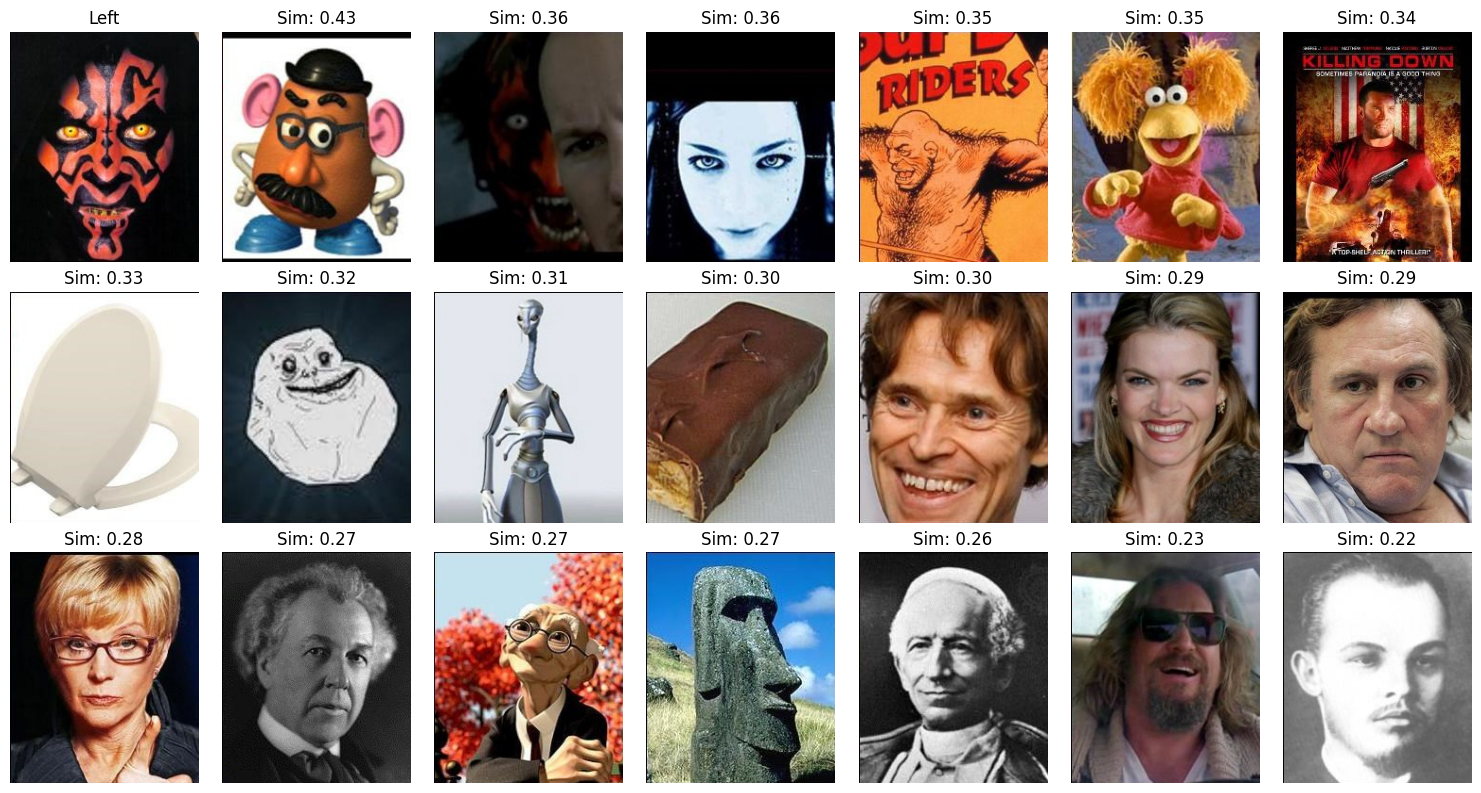

In [ ]:
import csv

# 定义一个函数来从CSV文件中获取right_image_names
def get_right_candidates_for_left(left_name, csv_file_path):
    with open(csv_file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            if row[0] == left_name:  # 第一列是left_image的名称
                return row[1:]  # 返回右边的候选者列表
    return None

def show_images(image_paths, similarities, rows=3, cols=7):
    """
    显示给定路径的图像和其相似度
    """

    plt.figure(figsize=(15, 8))

    # 加载并显示第一张图像
    left_image = Image.open(image_paths[0])
    plt.subplot(rows, cols, 1)  # Left image
    plt.imshow(left_image)
    plt.title("Left")
    plt.axis('off')

    # 按相似度排序
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)
    print("Length of image_paths:", len(image_paths))
    print("Length of similarities:", len(similarities))

    for i in range(len(similarities)):
        img = Image.open(image_paths[sorted_indices[i] + 1])
        plt.subplot(rows, cols, i+2)
        plt.imshow(img)
        plt.title(f"Sim: {similarities[sorted_indices[i]]:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 以下的代码不需要修改
sample_index = 17
left_name = output[sample_index][0]
csv_file_path = "COMP90086_2023_TLLdataset/test_candidates.csv"
right_image_names = get_right_candidates_for_left(left_name, csv_file_path)
left_path = f"COMP90086_2023_TLLdataset/test/left/{left_name}.jpg"
candidate_paths = [f"COMP90086_2023_TLLdataset/test/right/{name}.jpg" for name in right_image_names]

show_images([left_path] + candidate_paths, output[sample_index][1:])

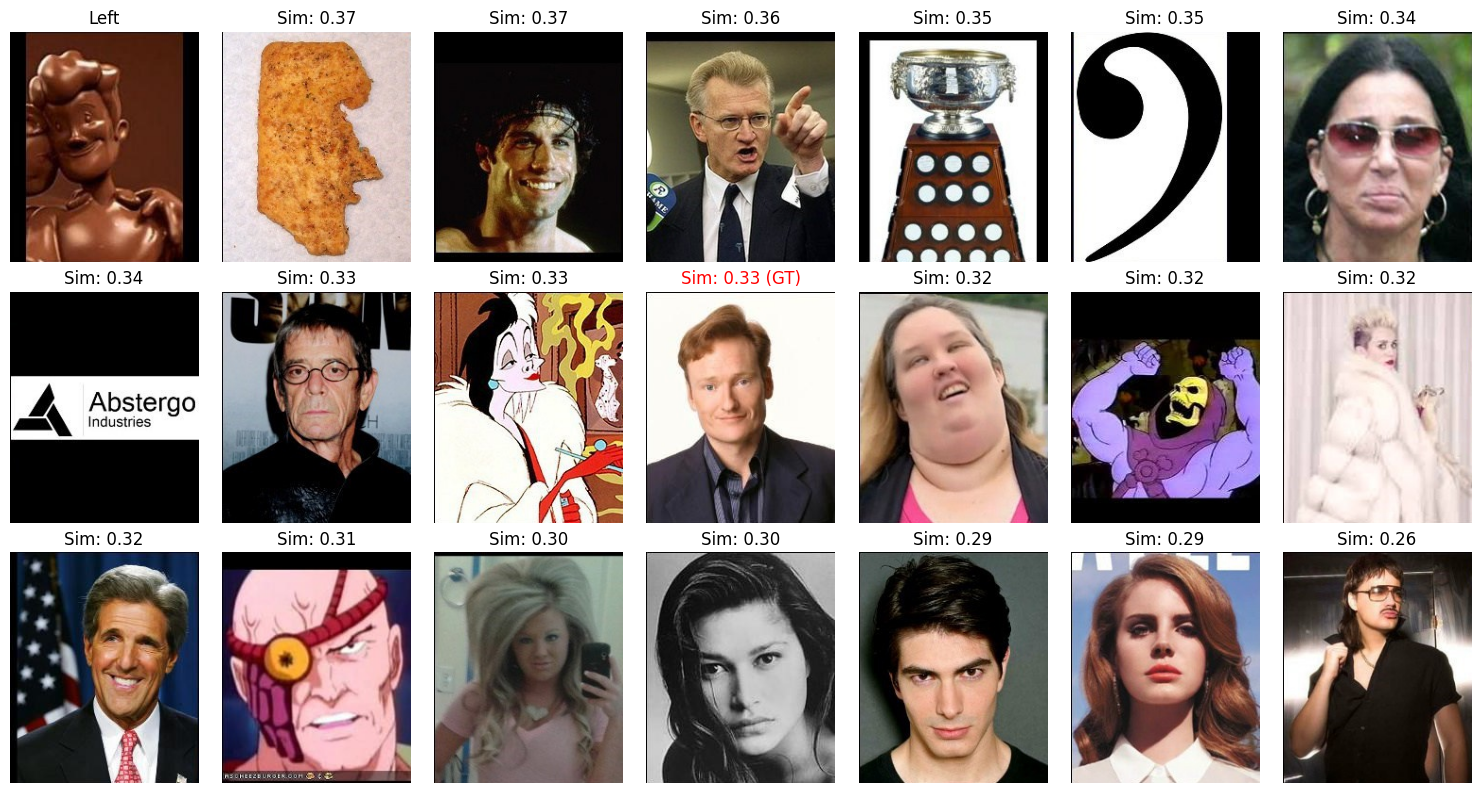

In [44]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_validation_images(image_paths, similarities, ground_truth_index, rows=3, cols=7):
    """
    显示给定路径的图像和其相似度。使用红色标记真实匹配。
    """

    plt.figure(figsize=(15, 8))

    # 加载并显示第一张图像
    left_image = Image.open(image_paths[0])
    plt.subplot(rows, cols, 1)  # Left image
    plt.imshow(left_image)
    plt.title("Left")
    plt.axis('off')

    # 按相似度排序
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)
    for i in range(len(similarities)):
        img = Image.open(image_paths[sorted_indices[i] + 1])
        plt.subplot(rows, cols, i+2)
        plt.imshow(img)
        title_text = f"Sim: {similarities[sorted_indices[i]]:.2f}"

        if sorted_indices[i] == ground_truth_index:
            title_text += " (GT)"
            plt.title(title_text, color='red')
        else:
            plt.title(title_text)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 读取CSV
df = pd.read_csv("COMP90086_2023_TLLdataset/train.csv")

# 随机选择一个left图像和一个right图像
selected_row = df.sample(19)
left_image = selected_row['left'].values[0]
right_image = selected_row['right'].values[0]

# 随机选择19个candidates
candidates = list(df['left'].values) + list(df['right'].values)
candidates = list(set(candidates))  # 去重
candidates.remove(left_image)  # 移除当前的left_image
selected_candidates = random.sample(candidates, 19)
selected_candidates.append(right_image)  # 加入原本的right图像

# 从train_merged_all_embeddings_512_v1中读取相应的图像的embeddings
embeddings_dir = "COMP90086_2023_TLLdataset/train_merged_all_embeddings_512_v1/"
left_embedding_path = os.path.join(embeddings_dir, 'left', left_image + ".npy")
left_embedding = np.load(left_embedding_path)

candidate_embeddings = []
for candidate in selected_candidates:
    if candidate in df['left'].values:
        candidate_path = os.path.join(embeddings_dir, 'left', candidate + ".npy")
    else:
        candidate_path = os.path.join(embeddings_dir, 'right', candidate + ".npy")
    candidate_embeddings.append(np.load(candidate_path))

# 使用model_shared的输出计算相似性
def compute_similarity(embed_left, embed_right):
    # 获取模型的adapted embeddings
    a_left = model_shared(torch.tensor(embed_left).cuda().unsqueeze(0))  # 加unsqueeze(0)以保证维度正确
    a_right = model_shared(torch.tensor(embed_right).cuda().unsqueeze(0))

    similarity = sim_matrix(a_left, a_right)

    return similarity.item()  # 将1x1 tensor转换为单个Python数值

# 计算相似度
similarities = [compute_similarity(left_embedding, candidate_embedding) for candidate_embedding in candidate_embeddings]

# 图片路径
left_image_dir = "COMP90086_2023_TLLdataset/train/left/"
right_image_dir = "COMP90086_2023_TLLdataset/train/right/"
left_image_path = left_image_dir + left_image
image_paths = [left_image_path + ".jpg"]
for candidate in selected_candidates:
    if candidate in df['left'].values:
        image_paths.append(left_image_dir + candidate + ".jpg")
    else:
        image_paths.append(right_image_dir + candidate + ".jpg")

# 调用show_validation_images函数
ground_truth_index = selected_candidates.index(right_image)
show_validation_images(image_paths, similarities, ground_truth_index)


### visual embeddings + siamese

In [ ]:
import pandas as pd

class PairwiseDataset(Dataset):
    def __init__(self, left_embeddings_dir, right_embeddings_dir, csv_path, transform=None):
        self.left_embeddings = [os.path.join(left_embeddings_dir, f) for f in os.listdir(left_embeddings_dir)]
        self.right_embeddings = [os.path.join(right_embeddings_dir, f) for f in os.listdir(right_embeddings_dir)]
        self.transform = transform

        # 读取CSV文件并为每个left图像创建一个字典来存储其匹配的right图像
        self.matching_dict = {}
        df = pd.read_csv(csv_path)
        for index, row in df.iterrows():
            left_path = os.path.join(left_embeddings_dir, row['left'] + '.npy')
            right_path = os.path.join(right_embeddings_dir, row['right'] + '.npy')
            self.matching_dict[left_path] = right_path

    def __len__(self):
        return len(self.left_embeddings)

    def __getitem__(self, idx):
        left_embedding = np.load(self.left_embeddings[idx])
        # 从字典中获取与left图像匹配的right图像
        matched_right_path = self.matching_dict[self.left_embeddings[idx]]

        # 我们随机选择19个右边的图像，并添加一个匹配的right图像作为候选项。
        random_choices = np.random.choice([path for path in self.right_embeddings if path != matched_right_path], 19, replace=False).tolist()
        random_choices.append(matched_right_path)

        right_embeddings = [np.load(path) for path in random_choices]
        return torch.Tensor(left_embedding), torch.stack([torch.Tensor(emb) for emb in right_embeddings])


In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256)
        )

    def forward_one(self, x):
        return self.fc(x)

    def forward(self, anchor, positive, negative):
        anchor_output = self.forward_one(anchor)
        positive_output = self.forward_one(positive)
        negative_output = self.forward_one(negative)
        return anchor_output, positive_output, negative_output

In [ ]:
from torch.utils.data import random_split

train_dataset = PairwiseDatasetSiamese('COMP90086_2023_TLLdataset/train_merged_embeddings_ViT_Facenet_256/left', 'COMP90086_2023_TLLdataset/train_merged_embeddings_ViT_Facenet_256/right','COMP90086_2023_TLLdataset/train.csv')

# 定义验证集的大小为原数据集的10%
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

# 使用random_split进行数据划分
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# 创建训练和验证的DataLoaders
train_loader = DataLoader(train_subset, batch_size=32,num_workers=2, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32,num_workers=2, shuffle=False)

# 模型、损失和优化器
siamese_network = SiameseNetwork(input_dim=256).cuda()
criterion = nn.TripletMarginLoss(margin=0.5)
optimizer = torch.optim.Adam(siamese_network.parameters(), lr=1e-5)

epochs=5

# 训练
for epoch in range(epochs):
    # 训练
    siamese_network.train()  # 设置模型为训练模式
    for anchor, positive, negative in train_loader:
        anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()

        optimizer.zero_grad()
        anchor_output, positive_output, negative_output = siamese_network(anchor, positive, negative)
        loss = criterion(anchor_output, positive_output, negative_output)
        loss.backward()
        optimizer.step()

    print(f"Training - Epoch {epoch}/{epochs}, Loss: {loss.item()}")

    # 在验证集上进行评估
    siamese_network.eval()  # 设置模型为评估模式
    total_loss = 0
    with torch.no_grad():
        for anchor, positive, negative in val_loader:
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
            anchor_output, positive_output, negative_output = siamese_network(anchor, positive, negative)
            loss = criterion(anchor_output, positive_output, negative_output)
            total_loss += loss.item()

    avg_val_loss = total_loss / len(val_loader)
    print(f"Validation - Epoch {epoch+1}/{epochs}, Avg Loss: {avg_val_loss}")


Training - Epoch 0/5, Loss: 3.573556900024414
Validation - Epoch 0/5, Avg Loss: 2.531787599836077
Training - Epoch 1/5, Loss: 0.0
Validation - Epoch 1/5, Avg Loss: 3.8830865791865756
Training - Epoch 2/5, Loss: 7.55462646484375
Validation - Epoch 2/5, Avg Loss: 3.8196165902273997
Training - Epoch 3/5, Loss: 3.3375625610351562
Validation - Epoch 3/5, Avg Loss: 2.790522745677403
Training - Epoch 4/5, Loss: 0.7027740478515625
Validation - Epoch 4/5, Avg Loss: 2.7985844952719554


In [ ]:
import csv
import numpy as np
import torch
import torch.nn.functional as F

# 确保模型处于评估模式
siamese_network.eval()

def compute_similarity(embed_left, embed_right):
    # 使用模型获取embeddings
    a_left,_,a_right = siamese_network(torch.tensor(embed_left).cuda().unsqueeze(0),torch.tensor(embed_left).cuda().unsqueeze(0),torch.tensor(embed_right).cuda().unsqueeze(0))  # 加unsqueeze(0)以保证维度正确

    # 计算余弦相似度
    similarity = F.cosine_similarity(a_left, a_right)

    return similarity.item()  # 将1x1 tensor转换为单个Python数值

# 加载test数据集的left和candidates的embeddings
def load_embedding(path):
    return np.load(path)

# 加载test_candidates.csv并计算相似度
output = []
with open('COMP90086_2023_TLLdataset/test_candidates.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        left_name = row[0]
        left_embedding = load_embedding(f"COMP90086_2023_TLLdataset/test_merged_embeddings_ViT_Facenet_256/left/{left_name}.npy")

        similarities = [left_name]
        for candidate_name in row[1:]:
            candidate_embedding = load_embedding(f"COMP90086_2023_TLLdataset/test_merged_embeddings_ViT_Facenet_256/right/{candidate_name}.npy")

            sim = compute_similarity(left_embedding, candidate_embedding)
            similarities.append(sim)

        output.append(similarities)

# 保存结果到CSV
with open('siamese_merged_256.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['left', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19'])
    for row in output:
        writer.writerow(row)
